In [1]:
import torch.nn    as nn
import torch.optim as optim
import GM_library  as GML
import numpy       as np
import torch
import json

from os                   import path, listdir
from torch.utils.data     import random_split
from torch_geometric.data import Data

import sys
sys.path.append('../')
import MP.MP_library as MPL

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Target to generate new crystals
target = 'GM_EPA'

# In case database is created from scratch (otherwise, it is not being used)
DB_path = '../MP/Loaded_EMP'

input_folder    = 'models'
target_folder   = f'{input_folder}/{target}'
edge_model_name = f'{target_folder}/edge_model.pt'
node_model_name = f'{target_folder}/node_model.pt'

In [3]:
# Define target value to look for
#seeked_target = ##

# Machine-learning parameters
n_epochs      = 300
batch_size    = 128
learning_rate = 0.0001

# Ratios for dividing training data
test_ratio = 0.1

# Number of diffusing and denoising steps
n_t_steps = 5

# Decay of parameter alpha
noise_contribution = 0.15
alpha_decay = 0.5 * (1 - noise_contribution**2)

# Dropouts for node and edge models (independent of each other)
dropout_node = 0.2
dropout_edge = 0.2

# Define box shape
L = [20, 20, 20]

# Create and save as a dictionary
model_parameters = {
    'n_epochs': n_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'test_ratio': test_ratio,
    'n_t_steps': n_t_steps,
    'noise_contribution': noise_contribution,
    'dropout_node': dropout_node,
    'dropout_edge': dropout_edge,
    'L': L
}

# Write the dictionary to the file in JSON format
with open(f'{target_folder}/model_parameters.json', 'w') as json_file:
    json.dump(model_parameters, json_file)

# Generation of graph database for training

Load the datasets, already standarized if possible.

In [4]:
labels_name         = f'{target_folder}/labels.pt'
dataset_name        = f'{target_folder}/dataset.pt'
dataset_name_std    = f'{target_folder}/standardized_dataset.pt'
parameters_name_std = f'{target_folder}/standardized_parameters.pt'  # Parameters for rescaling the predictions

if path.exists(dataset_name_std) and path.exists(parameters_name_std) and path.exists(labels_name):
    # Load the standardized dataset, with corresponding labels and parameters
    dataset    = torch.load(dataset_name_std)
    labels     = torch.load(labels_name)
    parameters = torch.load(parameters_name_std)

    # Assigning parameters accordingly
    target_mean, feat_mean, edge_mean, target_std, edge_std, feat_std, scale = parameters
    
    # Defining target factor
    target_factor = target_std / scale

elif path.exists(dataset_name) and path.exists(labels_name):
    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(dataset_name)
    labels  = torch.load(labels_name)
    
    # Standardize dataset
    dataset, parameters = GML.standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)

else:
    # Generate the raw dataset from scratch, and standardize it
    
    # Read all mateials within the database
    materials = listdir(DB_path)[:200]
    
    dataset = []
    labels  = []
    for material in materials:
        try:
            # Try to read the polyforms
            polymorfs = listdir(f'{DB_path}/{material}')
        except:
            continue
        
        print(material)
        for polymorf in polymorfs:
            # Path to folder containing the POSCAR
            path_to_POSCAR = f'{DB_path}/{material}/{polymorf}'
            
            # Check that the folder is valid
            if path.exists(f'{path_to_POSCAR}/POSCAR'):
                print(f'\t{polymorf}')

                # Extract parameters from POSCAR
                cell, composition, concentration, positions = MPL.information_from_VASPfile(path_to_POSCAR,
                                                                                            'POSCAR')

                # Generate POSCAR covering the box
                try:
                    nodes, edges, attributes, _, _, _ = GML.graph_POSCAR_encoding(cell,
                                                                                  composition,
                                                                                  concentration,
                                                                                  positions,
                                                                                  L)
                except:
                    print(f'Error: {material} {polymorf} not loaded')
                    continue

                # Load ground state energy per atom
                gs_energy = float(np.loadtxt(f'{path_to_POSCAR}/EPA'))

                # Construct temporal graph structure
                graph = Data(x=nodes,
                             edge_index=edges,
                             edge_attr=attributes,
                             y=torch.tensor([[gs_energy]], dtype=torch.float)
                            )

                # Append to dataset and labels
                dataset.append(graph)
                labels.append(f'{material}-{polymorf}')
    
    # Standardize dataset
    dataset, parameters = GML.standardize_dataset(dataset)
    
    # Save standardized dataset
    torch.save(dataset,    dataset_name_std)
    torch.save(parameters, parameters_name_std)
    torch.save(labels,     labels_name)

# Definition of train-test datasets

In [5]:
# torch.manual_seed(12345)

# Define the sizes of the train and test sets
test_size  = int(test_ratio * len(dataset))
train_size = len(dataset) - test_size

# Use random_split() to generate train and test sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of testing  graphs: {len(test_dataset)}')

Number of training graphs: 245
Number of testing  graphs: 27


# Training of the model

In [6]:
# Determine number of features in dataset, considering the t_step information
n_features = dataset[0].num_node_features + 1

# Instantiate the models for nodes and edges
node_model = GML.nGCNN(n_features, dropout_node).to(device)
edge_model = GML.eGCNN(n_features, dropout_edge).to(device)
print('\nNode GCNN:')
print(node_model)
print('\nEdge GCNN:')
print(edge_model)


Node GCNN:
nGCNN(
  (conv1): GraphConv(5, 256)
  (conv2): GraphConv(256, 256)
  (conv3): GraphConv(256, 5)
)

Edge GCNN:
eGCNN(
  (linear1): Linear(in_features=6, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Initialize the optimizers
node_optimizer = torch.optim.Adam(node_model.parameters(), lr=learning_rate)
edge_optimizer = torch.optim.Adam(edge_model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
for epoch in range(n_epochs):
    # Initialize train loss variable
    train_loss = 0
    graph_counter = 0
    for graph in train_dataset:
        # Count new graph
        graph_counter += 1
        
        #print()
        #print(f'Graph: {graph_counter}')
        # Clone existing graph
        graph_0 = graph.clone()
        
        # Initialize the gradient of the optimizers
        node_optimizer.zero_grad()
        edge_optimizer.zero_grad()
        
        # Start denoising-diffusing process
        for t_step in np.arange(1, n_t_steps+1):
            # Diffuse the graph with some noise
            #print()
            #print(f'Step: {t_step}')
            #print('Diffusing...')
            
            graph_t, epsilon_t = GML.diffusion_step(graph_0, t_step, n_t_steps, alpha_decay)
            
            # Update diffused graph as next one
            graph_0 = graph_t.clone()

            # Denoise the diffused graph
            #print(f'Denoising...')
            
            # Add t_step information to graph_t
            graph_t = GML.add_t_information(graph_t, t_step)

            # Perform a single forward pass for predicting node features
            out_x = node_model(graph_t.x,
                               graph_t.edge_index,
                               graph_t.edge_attr)
            
            # Remove t_step information
            out_x = out_x[:, :-1]

            # Define x_i and x_j as features of every corresponding pair of nodes (same order than attributes)
            x_i = graph_t.x[graph_t.edge_index[0]]
            x_j = graph_t.x[graph_t.edge_index[1]]

            # Perform a single forward pass for predicting edge attributes
            # Introduce previous edge attributes as features as well
            out_attr = edge_model(x_i, x_j, graph_t.edge_attr)

            # Construct noise graph
            pred_epsilon_t = Data(x=out_x,
                                  edge_index=graph_t.edge_index,
                                  edge_attr=out_attr.ravel())
            
            # Backpropagation and optimization step
            #print('Backpropagating...')

            # Calculate the loss for node features and edge attributes
            node_loss, edge_loss = GML.get_graph_losses(epsilon_t, pred_epsilon_t)
            
            # Backpropagate and optimize node loss
            node_loss.backward(retain_graph=True)
            node_optimizer.step()

            # Backpropagate and optimize edge loss
            edge_loss.backward(retain_graph=True)
            edge_optimizer.step()

            # Predict target for current graph
            #predicted_target = ###

            # Compute target loss
            #target_loss = GML.get_target_loss(predicted_target, seeked_target)
            target_loss = 0

            # Accumulate the total training loss
            loss = node_loss + edge_loss + target_loss
            train_loss += loss.item()
    
    # Compute the average train loss
    train_loss = train_loss / (len(train_dataset) * n_t_steps)
    train_losses.append(train_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    
    if (epoch % 20) == 0:
        torch.save(edge_model.state_dict(), edge_model_name)
        torch.save(node_model.state_dict(), node_model_name)

In [12]:
# More epochs

Epoch: 87, Train Loss: 3597.9376
Epoch: 88, Train Loss: 548.2471
Epoch: 89, Train Loss: 521.3447
Epoch: 90, Train Loss: 356.4804
Epoch: 91, Train Loss: 51.8309
Epoch: 92, Train Loss: 44.7267
Epoch: 93, Train Loss: 47.7502
Epoch: 94, Train Loss: 58.0972
Epoch: 95, Train Loss: 153.2682
Epoch: 96, Train Loss: 387.4881
Epoch: 97, Train Loss: 299.8269
Epoch: 98, Train Loss: 1286.3857
Epoch: 99, Train Loss: 223.5428
Epoch: 100, Train Loss: 251.2387
Epoch: 101, Train Loss: 103.4156
Epoch: 102, Train Loss: 143.9703
Epoch: 103, Train Loss: 23.7049
Epoch: 104, Train Loss: 17.9608
Epoch: 105, Train Loss: 10.4106
Epoch: 106, Train Loss: 37.8909
Epoch: 107, Train Loss: 201.7577
Epoch: 108, Train Loss: 67.2388
Epoch: 109, Train Loss: 64.9326
Epoch: 110, Train Loss: 33.9018
Epoch: 111, Train Loss: 64.9407
Epoch: 112, Train Loss: 107.1725
Epoch: 113, Train Loss: 24.8852
Epoch: 114, Train Loss: 35.9621
Epoch: 115, Train Loss: 21.6648
Epoch: 116, Train Loss: 8.2632
Epoch: 117, Train Loss: 5.8387
Epoch: 

KeyboardInterrupt: 

In [10]:
torch.save(edge_model.state_dict(), edge_model_name)
torch.save(node_model.state_dict(), node_model_name)

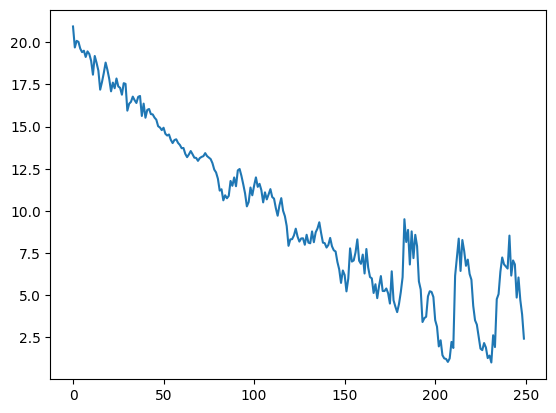

In [13]:
import matplotlib.pyplot as plt
plt.plot(np.log(train_losses))